Assignment 1

Preparation:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
df = pd.read_excel('DataLab1.xlsx', sheet_name=0)
df['Loss'] = -df['PL']
print(df.info())
df.head()

<class 'pandas.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1008 non-null   datetime64[us]
 1   PL      1008 non-null   int64         
 2   Loss    1008 non-null   int64         
dtypes: datetime64[us](1), int64(2)
memory usage: 23.8 KB
None


,Date,PL,Loss
0,2005-01-01,190,-190
1,2005-01-02,190,-190
2,2005-01-03,-220,220
3,2005-01-05,120,-120
4,2005-01-06,450,-450


Question 1

In [5]:
T = 500
alpha = 0.99
target_rank = int((1 - alpha) * T) + 1
target_index = target_rank - 1

def get_bhs_var(window):
    sorted_losses = np.sort(window)[::-1]
    return sorted_losses[target_index]

def get_bhs_es(window):
    sorted_losses = np.sort(window)[::-1]
    return sorted_losses[:target_index].mean()

df['VaR_BHS'] = df['Loss'].rolling(window=T).apply(get_bhs_var, raw=True)
df['ES_BHS'] = df['Loss'].rolling(window=T).apply(get_bhs_es, raw=True)

test_results = df.iloc[500:].copy()

df['VaR_BHS'] = df['VaR_BHS'].shift(1)
df['ES_BHS'] = df['ES_BHS'].shift(1)

# Print the first 20 rows of the test period
print("--- Detailed Test Period Results (First 20 Days) ---")
display(test_results[['Loss', 'VaR_BHS', 'ES_BHS']].head(20))

--- Detailed Test Period Results (First 20 Days) ---


,Loss,VaR_BHS,ES_BHS
500,150,1050.0,1582.0
501,-150,1050.0,1582.0
502,20,1050.0,1582.0
503,-30,1050.0,1582.0
504,-30,1050.0,1582.0
505,-200,1050.0,1582.0
506,110,1050.0,1582.0
507,-50,1050.0,1582.0
508,-160,1050.0,1582.0
509,-50,1050.0,1582.0


Question 2

In [6]:
#Calculation of fixed mean
mu_fixed = df['Loss'].iloc[:500].mean()
print(f"The fixed expected loss (mu) is: {mu_fixed:.4f}")

#Create unexepcted loss column
df['Unexpected_Loss'] = df['Loss'] - mu_fixed

The fixed expected loss (mu) is: -44.0800


EWMA model to observe variance observations

In [7]:
#Set parameters from assignment
lambda_val = 0.94
e0_sq = 0
sigma0_sq = df['Loss'].iloc[:500].var()

#Initiate new column in dataframe
df['Variance_EWMA'] = 0.0

variances = []
prev_e_sq = e0_sq
prev_sigma_sq = sigma0_sq

for et in df['Unexpected_Loss']:
    current_sigma_sq = (1 - lambda_val) * prev_e_sq + lambda_val * prev_sigma_sq
    
    variances.append(current_sigma_sq)
    
    prev_e_sq = et**2
    prev_sigma_sq = current_sigma_sq

# Add the results back to the DataFrame
df['Variance_EWMA'] = variances

df['Sigma_EWMA'] = np.sqrt(df['Variance_EWMA'])
df.head()

,Date,PL,Loss,VaR_BHS,ES_BHS,Unexpected_Loss,Variance_EWMA,Sigma_EWMA
0,2005-01-01,190,-190,NaN,NaN,-145.92,117250.733852,342.418945
1,2005-01-02,190,-190,NaN,NaN,-145.92,111493.248605,333.906048
2,2005-01-03,-220,220,NaN,NaN,264.08,106081.212472,325.701109
3,2005-01-05,120,-120,NaN,NaN,-75.92,103900.634508,322.336213
4,2005-01-06,450,-450,NaN,NaN,-405.92,98012.427222,313.069365


Question 3:
Construct volatility scaled losses by using the standard deviations calculated in 2c. Recall that we need an estimate of 𝜎𝑇+1 to construct the scaled losses, i.e. an estimate of volatility for ‘’the next day’’. This means that we have to reconstruct the whole series of scaled losses or each new 𝜎𝑇+1, so we have to create as many new rescaled loss series as we have days in the test period. That is your matrix of scaled losses should by 500x508.

In [8]:
rT = 500
T_total = len(df)
scaled_losses = np.zeros((rT, T_total - rT))

losses_all = df['Loss'].values
sigmas_all = df['Sigma_EWMA'].values

for j in range(rT, T_total):
    sigma_next_day = sigmas_all[j]
    window_losses = losses_all[j - rT : j]
    window_sigmas = sigmas_all[j - rT : j]
    scaled_losses[:, j - rT] = window_losses * (sigma_next_day / window_sigmas)



Question 4

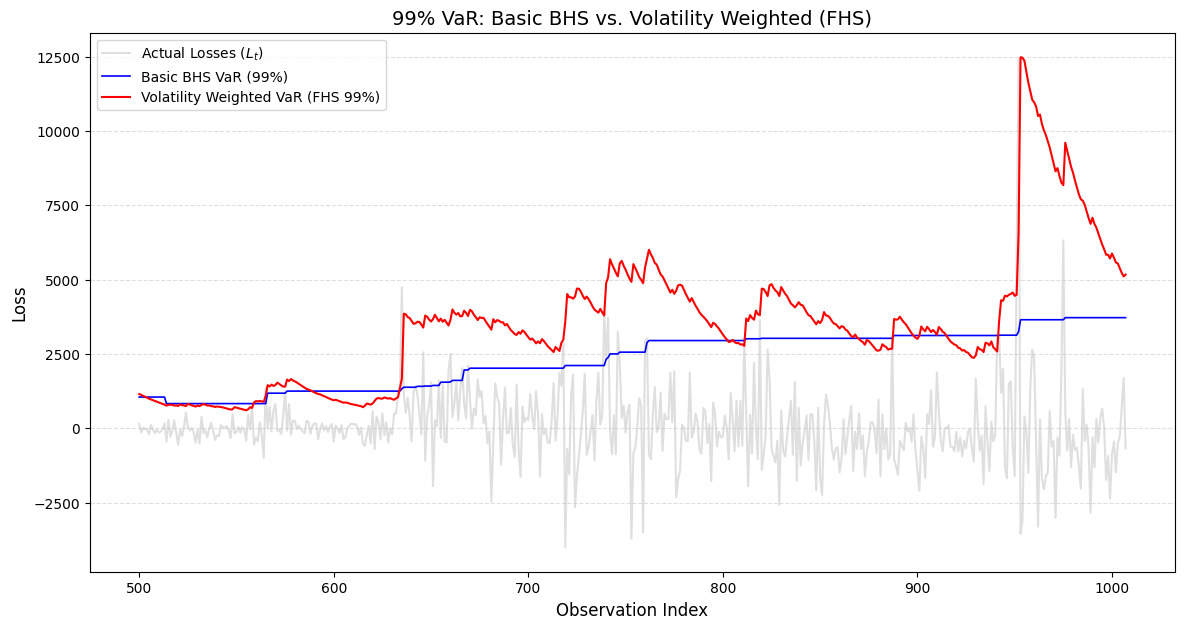

In [9]:
fhs_var = []
fhs_es = []

for col_idx in range(scaled_losses.shape[1]):
    current_column = scaled_losses[:, col_idx]
    sorted_col = np.sort(current_column)[::-1]
    fhs_var.append(sorted_col[5])
    fhs_es.append(sorted_col[:5].mean())

df.loc[df.index[rT:], 'VaR_FHS'] = fhs_var
df.loc[df.index[rT:], 'ES_FHS'] = fhs_es

test_period = df.iloc[rT:].copy()

plt.figure(figsize=(14, 7))

plt.plot(test_period.index, test_period['Loss'], 
         color='silver', alpha=0.5, label='Actual Losses ($L_t$)')

plt.plot(test_period.index, test_period['VaR_BHS'], 
         color='blue', linewidth=1.2, label='Basic BHS VaR (99%)')

plt.plot(test_period.index, test_period['VaR_FHS'], 
         color='red', linewidth=1.5, label='Volatility Weighted VaR (FHS 99%)')

plt.title('99% VaR: Basic BHS vs. Volatility Weighted (FHS)', fontsize=14)
plt.xlabel('Observation Index', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.4)

plt.show()

Question 5

In [13]:
# 1. Calculate the four moments for your Loss data
mean_loss = df['Loss'].mean()
var_loss  = df['Loss'].var()
skew_loss = stats.skew(df['Loss'])
kurt_loss = stats.kurtosis(df['Loss'], fisher=True) # Excess Kurtosis

# 2. Formal Normality Test
jb_stat, jb_p_value = stats.jarque_bera(df['Loss'])

# 3. Display results in a clean table
results = pd.DataFrame({
    "Moment/Test": ["Mean", "Variance", "Skewness", "Excess Kurtosis", "JB Stat", "JB p-value"],
    "Value": [mean_loss, var_loss, skew_loss, kurt_loss, jb_stat, jb_p_value]
})

print(results)

       Moment/Test          Value
0             Mean       1.205357
1         Variance  922412.622136
2         Skewness       2.870699
3  Excess Kurtosis      32.706671
4          JB Stat   46312.978202
5       JB p-value       0.000000


The loss data does not look normally distributed. Skew is significantly positive and most of all excess kurtosis is way above 0. 
As for similarity to S&P500 returns they look similar, but mirrored (as it is loss data instead of positive return that makes sense). The values for skewness and excess kurtosis are significantly larger in magnitude than what we saw in class for S&P500 returns where skewness was below 1 and daily returns showed excess kurtosis of 16.

In [ ]:
norm_mu = []
norm_sigma = []

t_mu = []
t_sigma = []
t_nu = []

losses_all = df['Loss'].values
rT = 500
T_total = len(df)

for j in range(rT, T_total):
    window = losses_all[j - rT : j]

    n_mu, n_sigma = stats.norm.fit(window)
    norm_mu.append(n_mu)
    norm_sigma.append(n_sigma)
    
    df_fit, loc_fit, scale_fit = stats.t.fit(window)
    t_nu.append(df_fit)
    t_mu.append(loc_fit)
    t_sigma.append(scale_fit)

df.loc[df.index[rT:], 'Norm_Mu'] = norm_mu
df.loc[df.index[rT:], 'Norm_Sigma'] = norm_sigma

df.loc[df.index[rT:], 't_Mu'] = t_mu
df.loc[df.index[rT:], 't_Sigma'] = t_sigma
df.loc[df.index[rT:], 't_Nu'] = t_nu

,Date,PL,Loss,VaR_BHS,ES_BHS,Unexpected_Loss,Variance_EWMA,Sigma_EWMA,VaR_FHS,ES_FHS,Norm_Mu,Norm_Sigma,t_Mu,t_Sigma,t_Nu
0,2005-01-01,190,-190,NaN,NaN,-145.92,117250.733852,342.418945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-02,190,-190,NaN,NaN,-145.92,111493.248605,333.906048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-03,-220,220,NaN,NaN,264.08,106081.212472,325.701109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-01-05,120,-120,NaN,NaN,-75.92,103900.634508,322.336213,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-06,450,-450,NaN,NaN,-405.92,98012.427222,313.069365,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#KOLLA IGENOM KODEN TILL DENNA UPPGIFT, inte gjort det

mu_n = df['Norm_Mu'].values
sigma_n = df['Norm_Sigma'].values

mu_t = df['t_Mu'].values
sigma_t = df['t_Sigma'].values
nu_t = df['t_Nu'].values

var_n = np.full(len(df), np.nan)
es_n = np.full(len(df), np.nan)
var_t = np.full(len(df), np.nan)
es_t = np.full(len(df), np.nan)

# 4. Loop through the test period (indices where we have parameters)
for j in range(rT, T_total):
    # --- NORMAL DISTRIBUTION ---
    # VaR: Normal inverse CDF
    var_n[j] = stats.norm.ppf(alpha, loc=mu_n[j], scale=sigma_n[j])
    
    # ES: Formula for Normal ES = mu + sigma * (pdf(z) / (1-alpha))
    z = stats.norm.ppf(alpha)
    es_n[j] = mu_n[j] + sigma_n[j] * (stats.norm.pdf(z) / (1 - alpha))
    
    # --- STUDENT-T DISTRIBUTION ---
    # Apply the guardrail: nu must be > 2 for ES to be well-defined
    current_nu = nu_t[j]
    if current_nu < 2:
        current_nu = 2.1
        
    # VaR: Student-t inverse CDF
    var_t[j] = stats.t.ppf(alpha, df=current_nu, loc=mu_t[j], scale=sigma_t[j])
    
    # ES: Formula for Student-t ES
    # Note: This is the specific analytical solution for Student-t ES
    x_nu = stats.t.ppf(alpha, df=current_nu)
    factor = (current_nu + x_nu**2) / (current_nu - 1)
    es_t[j] = mu_t[j] + sigma_t[j] * (stats.t.pdf(x_nu, df=current_nu) / (1 - alpha)) * factor

# 5. Assign back to DataFrame
df['VaR_Normal'] = var_n
df['ES_Normal'] = es_n
df['VaR_t'] = var_t
df['ES_t'] = es_t

print(df[['VaR_Normal', 'VaR_t']].dropna().tail())

       VaR_Normal        VaR_t
1003  3096.544537  3894.838014
1004  3096.119900  3885.509714
1005  3095.779477  3882.021768
1006  3098.150772  3869.046526
1007  3106.087492  3864.243081


Question 6

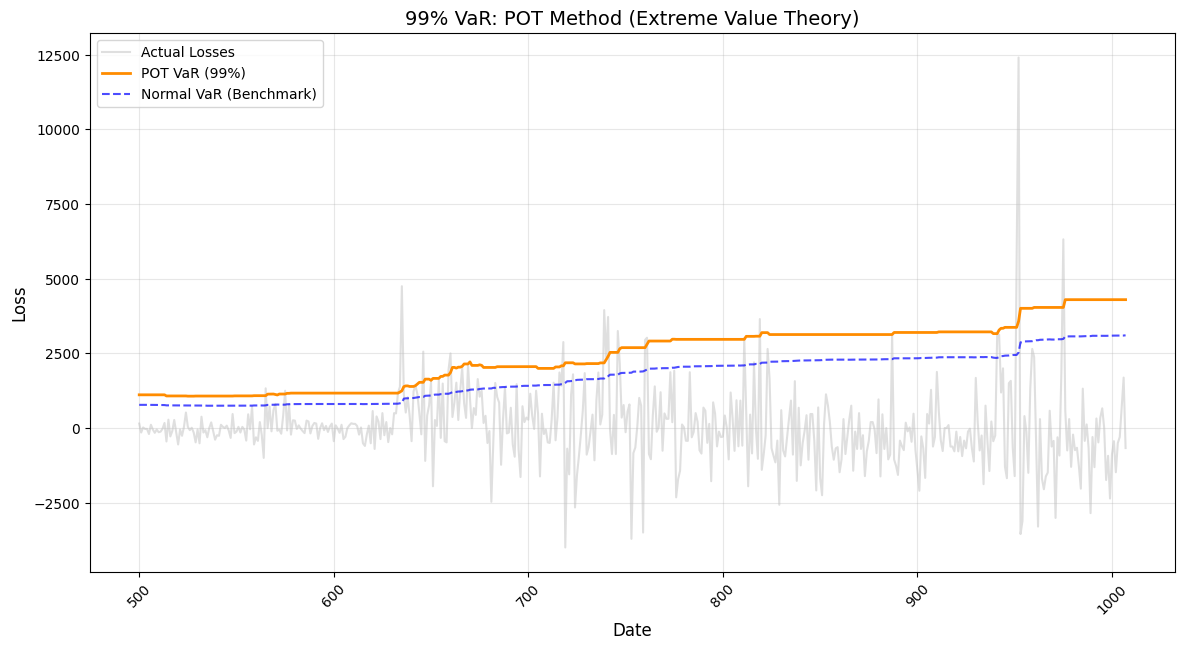

In [ ]:
#KOLLA IGENOM KODEN TILL DENNA UPPGIFT, inte gjort det

from scipy.stats import genpareto

# Parameters
rT = 500
T_total = len(df)
alpha = 0.99
target_percentile = 0.95 # Threshold is the 5% largest values

# Arrays to store results
var_pot = np.full(len(df), np.nan)
es_pot = np.full(len(df), np.nan)

losses_all = df['Loss'].values

for j in range(rT, T_total):
    # 1. Get the rolling window
    window = losses_all[j - rT : j]
    
    # 2. Set threshold u (95th percentile)
    u = np.percentile(window, target_percentile * 100)
    
    # 3. Get excesses (only values strictly larger than u)
    excesses = window[window > u] - u
    Nu = len(excesses)
    N = len(window)
    
    # 4. Fit Generalized Pareto Distribution (GPD)
    # c is the shape parameter (xi), loc is usually 0, scale is beta
    xi, loc, beta = genpareto.fit(excesses, floc=0)
    
    # 5. Calculate POT VaR
    # Formula: u + (beta/xi) * [ ((N/Nu)*(1-alpha))^-xi - 1 ]
    term = (N / Nu) * (1 - alpha)
    var_pot[j] = u + (beta / xi) * (term**(-xi) - 1)
    
    # 6. Calculate POT ES
    # Formula: (VaR + beta - xi*u) / (1 - xi)
    es_pot[j] = (var_pot[j] + beta - xi * u) / (1 - xi)

# Save to DataFrame
df['VaR_POT'] = var_pot
df['ES_POT'] = es_pot

test_period = df.iloc[rT:].copy()

plt.figure(figsize=(14, 7))

# Actual losses
plt.plot(test_period.index, test_period['Loss'], 
         color='silver', alpha=0.5, label='Actual Losses')

# POT VaR
plt.plot(test_period.index, test_period['VaR_POT'], 
         color='darkorange', linewidth=2, label='POT VaR (99%)')

# Optional: Add the Normal VaR for comparison to see the tail difference
plt.plot(test_period.index, test_period['VaR_Normal'], 
         color='blue', linestyle='--', alpha=0.7, label='Normal VaR (Benchmark)')

plt.title('99% VaR: POT Method (Extreme Value Theory)', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.show()